## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    print("CUDA NOT AVAILABLE")
device = torch.device(device)

net = Net().to(device)
print(net)

/home/igor/projects/ml_utils/cv_course_udacity/p1_facial_keypoints/models.py:13: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/home/igor/projects/ml_utils/cv_course_udacity/p1_facial_keypoints/models.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)


Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): CELU(alpha=1.0, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): CELU(alpha=1.0, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): CELU(alpha=1.0, inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=33856, out_features=1024, bias=True)
    (2): CELU(alpha=1.0, inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): CELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=1024, out_features=136, bias=True)
  )
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor, RandomFlip, RandomRotate


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([
    Rescale(240),
    RandomCrop(200), 
    RandomFlip(), 
    RandomRotate(),
    Normalize(), 
    ToTensor(),
])

val_data_transform = transforms.Compose([
    Rescale(240),
    RandomCrop(200), 
    Normalize(), 
    ToTensor(),
])


# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


(200, 200, 3)


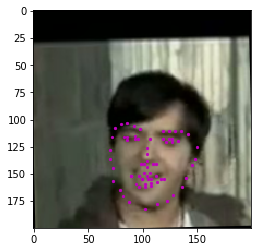

(200, 200, 3)


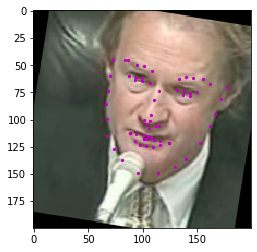

(200, 200, 3)


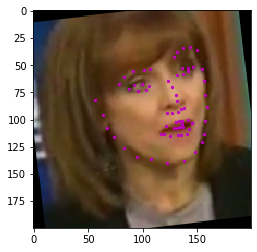

(200, 200, 3)


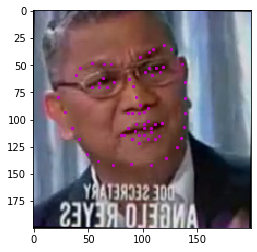

(200, 200, 3)


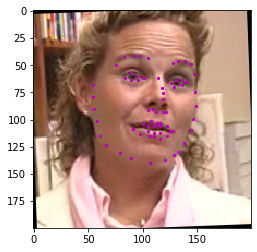

(200, 200, 3)


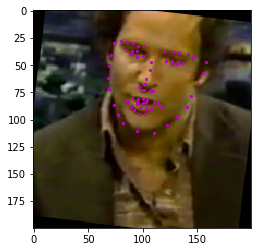

(200, 200, 3)


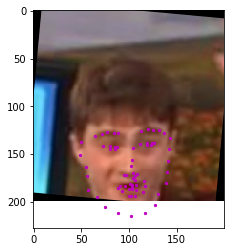

(200, 200, 3)


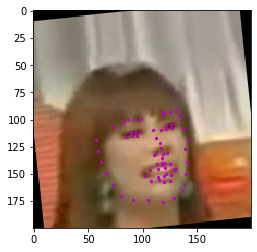

(200, 200, 3)


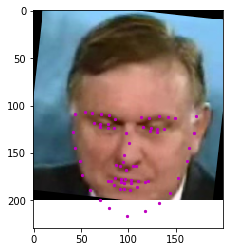

(200, 200, 3)


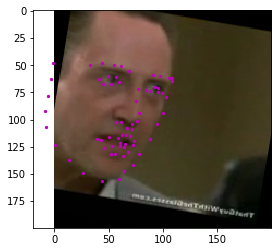

(200, 200, 3)


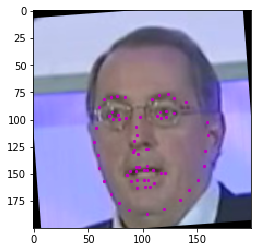

(200, 200, 3)


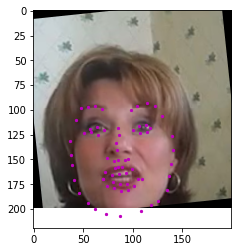

(200, 200, 3)


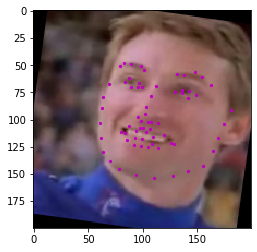

(200, 200, 3)


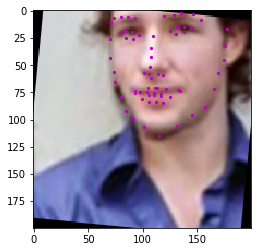

In [5]:
debug_transform = transforms.Compose([
    Rescale(240),
    RandomCrop(200), 
    RandomFlip(True), 
    RandomRotate()
])

debug_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=debug_transform)

for i in range(14):
    sample = debug_dataset[i]
    img = np.squeeze(sample["image"])
    print(img.shape)
    show_all_keypoints(img, sample["keypoints"])

    plt.show()

In [6]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 200, 200]) torch.Size([68, 2])
1 torch.Size([1, 200, 200]) torch.Size([68, 2])
2 torch.Size([1, 200, 200]) torch.Size([68, 2])
3 torch.Size([1, 200, 200]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [7]:
# load training data in batches
batch_size = 64

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=8)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=val_data_transform)



In [9]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=8)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        net.eval()
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images.cpu(), output_pts.cpu(), key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [11]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 200, 200])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

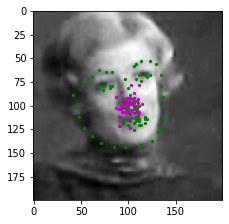

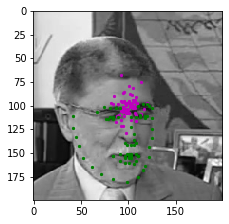

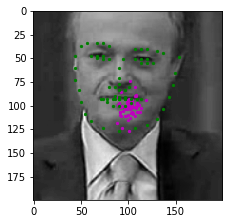

In [12]:
### visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(3):
        plt.figure(figsize=(40,20))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
            
        print("")
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        #plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

# l2 for abs(x) < 1, L1 othersie
criterion = nn.SmoothL1Loss() # nn.MSELoss()  #

learning_rate = 1e-3
l2_loss = 1e-5
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=l2_loss, amsgrad=True)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def early_stop(val_losses):
    waiting_epochs = 30
    if len(val_losses) <= waiting_epochs:
        return False
    val_losses = val_losses[-waiting_epochs:]
    if min(val_losses) == val_losses[0]:
        return True
    else:
        return False


def train_net(n_epochs):

    # prepare the net for training
    net.train()
    total_iters = len(train_loader)
    print_freq = int(total_iters*0.2)
    print("print every: ", print_freq)

    tr_epoch_losses = []
    val_epoch_losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        tr_epoch_loss = 0.0
        val_epoch_loss = 0.0
        
        net.train()

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            torch.cuda.empty_cache()

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()
            
            torch.cuda.empty_cache()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += float(loss)
            tr_epoch_loss += float(loss)
            del loss
            if batch_i % print_freq == (print_freq-1):    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/print_freq))
                running_loss = 0.0
        tr_epoch_loss = tr_epoch_loss / len(train_loader)
        tr_epoch_losses.append(tr_epoch_loss)
        print("Training loss: ", tr_epoch_loss)
        tr_epoch_loss = 0.0
        
        with torch.no_grad():
            net.eval()
            for batch_i, data in enumerate(test_loader):
                
                images = data['image']
                key_pts = data['keypoints']

                key_pts = key_pts.view(key_pts.size(0), -1)

                torch.cuda.empty_cache()

                key_pts = key_pts.type(torch.FloatTensor).to(device)
                images = images.type(torch.FloatTensor).to(device)

                # forward pass to get outputs
                output_pts = net(images)

                # calculate the loss between predicted and target keypoints
                loss = criterion(output_pts, key_pts)

                # zero the parameter (weight) gradients
                optimizer.zero_grad()
                torch.cuda.empty_cache()

                val_epoch_loss += float(loss)
                
            val_epoch_loss = val_epoch_loss / len(test_loader)
            val_epoch_losses.append(val_epoch_loss)
            print("Validation loss: ", val_epoch_loss)
            val_epoch_loss = 0.0
            
        if early_stop(val_epoch_losses):
            print("Early stopping at epoch ", epoch)
            break
            

    print('Finished Training')
    return tr_epoch_losses, val_epoch_losses


In [15]:
# train your network
n_epochs = 300 

tr_loss, val_loss = train_net(n_epochs)

print every:  11
Epoch: 1, Batch: 11, Avg. Loss: 0.6112838956442747
Epoch: 1, Batch: 22, Avg. Loss: 0.1916382990100167
Epoch: 1, Batch: 33, Avg. Loss: 0.1462740037928928
Epoch: 1, Batch: 44, Avg. Loss: 0.11728628047487953
Epoch: 1, Batch: 55, Avg. Loss: 0.10075520453127948
Training loss:  0.23344753669066862
Validation loss:  0.07712215471726197
Epoch: 2, Batch: 11, Avg. Loss: 0.09994901107116179
Epoch: 2, Batch: 22, Avg. Loss: 0.08601152761416002
Epoch: 2, Batch: 33, Avg. Loss: 0.09157164598053152
Epoch: 2, Batch: 44, Avg. Loss: 0.09000627628781578
Epoch: 2, Batch: 55, Avg. Loss: 0.07769724252549084
Training loss:  0.08904714069583199
Validation loss:  0.06194647745444225
Epoch: 3, Batch: 11, Avg. Loss: 0.08858225901018489
Epoch: 3, Batch: 22, Avg. Loss: 0.08224229311401193
Epoch: 3, Batch: 33, Avg. Loss: 0.07537822357632896
Epoch: 3, Batch: 44, Avg. Loss: 0.07802141999656503
Epoch: 3, Batch: 55, Avg. Loss: 0.08094348419796336
Training loss:  0.08103353597901085
Validation loss:  0.08

Epoch: 25, Batch: 33, Avg. Loss: 0.045037076554515144
Epoch: 25, Batch: 44, Avg. Loss: 0.04347734779796817
Epoch: 25, Batch: 55, Avg. Loss: 0.042298478497700256
Training loss:  0.04294099679047411
Validation loss:  0.033914704305621296
Epoch: 26, Batch: 11, Avg. Loss: 0.048222569918090645
Epoch: 26, Batch: 22, Avg. Loss: 0.04394140670245344
Epoch: 26, Batch: 33, Avg. Loss: 0.04038611426949501
Epoch: 26, Batch: 44, Avg. Loss: 0.037220145321705124
Epoch: 26, Batch: 55, Avg. Loss: 0.038518867032094437
Training loss:  0.04165782064876773
Validation loss:  0.03173318591255408
Epoch: 27, Batch: 11, Avg. Loss: 0.04214005121453242
Epoch: 27, Batch: 22, Avg. Loss: 0.04317062771455808
Epoch: 27, Batch: 33, Avg. Loss: 0.03960553218017925
Epoch: 27, Batch: 44, Avg. Loss: 0.04573365571823987
Epoch: 27, Batch: 55, Avg. Loss: 0.042900826443325386
Training loss:  0.042710138654167
Validation loss:  0.03411269746720791
Epoch: 28, Batch: 11, Avg. Loss: 0.039498725228688934
Epoch: 28, Batch: 22, Avg. Los

Epoch: 49, Batch: 44, Avg. Loss: 0.034263655204664574
Epoch: 49, Batch: 55, Avg. Loss: 0.03602428734302521
Training loss:  0.03643577457828955
Validation loss:  0.02446241880981968
Epoch: 50, Batch: 11, Avg. Loss: 0.03276638449593024
Epoch: 50, Batch: 22, Avg. Loss: 0.03690481795506044
Epoch: 50, Batch: 33, Avg. Loss: 0.03022319044579159
Epoch: 50, Batch: 44, Avg. Loss: 0.035280298949642616
Epoch: 50, Batch: 55, Avg. Loss: 0.040007654916156425
Training loss:  0.03503646935251626
Validation loss:  0.027191641740500927
Epoch: 51, Batch: 11, Avg. Loss: 0.03974721902473406
Epoch: 51, Batch: 22, Avg. Loss: 0.03312240625646981
Epoch: 51, Batch: 33, Avg. Loss: 0.03604248183017427
Epoch: 51, Batch: 44, Avg. Loss: 0.03124112110923637
Epoch: 51, Batch: 55, Avg. Loss: 0.03547170842913064
Training loss:  0.03512498732994903
Validation loss:  0.036030264428028695
Epoch: 52, Batch: 11, Avg. Loss: 0.039223092862150886
Epoch: 52, Batch: 22, Avg. Loss: 0.032548716122453865
Epoch: 52, Batch: 33, Avg. Lo

Epoch: 73, Batch: 44, Avg. Loss: 0.03344611366364089
Epoch: 73, Batch: 55, Avg. Loss: 0.02621850777756084
Training loss:  0.028179767863316968
Validation loss:  0.020775434489433583
Epoch: 74, Batch: 11, Avg. Loss: 0.02888656509193507
Epoch: 74, Batch: 22, Avg. Loss: 0.02706514366648414
Epoch: 74, Batch: 33, Avg. Loss: 0.029827003959905018
Epoch: 74, Batch: 44, Avg. Loss: 0.031823641366579315
Epoch: 74, Batch: 55, Avg. Loss: 0.026210230267183346
Training loss:  0.02876251687041738
Validation loss:  0.021593957351377376
Epoch: 75, Batch: 11, Avg. Loss: 0.03175127438523553
Epoch: 75, Batch: 22, Avg. Loss: 0.029211936687881298
Epoch: 75, Batch: 33, Avg. Loss: 0.025140276009386234
Epoch: 75, Batch: 44, Avg. Loss: 0.028367248787121338
Epoch: 75, Batch: 55, Avg. Loss: 0.027643321759321472
Training loss:  0.028422811525789175
Validation loss:  0.022811715670216542
Epoch: 76, Batch: 11, Avg. Loss: 0.028197969563982704
Epoch: 76, Batch: 22, Avg. Loss: 0.03443177772516554
Epoch: 76, Batch: 33, A

Epoch: 97, Batch: 44, Avg. Loss: 0.03527044826610522
Epoch: 97, Batch: 55, Avg. Loss: 0.025174544954841786
Training loss:  0.02775558866560459
Validation loss:  0.016231724813293952
Epoch: 98, Batch: 11, Avg. Loss: 0.025199036875909023
Epoch: 98, Batch: 22, Avg. Loss: 0.024026107043027878
Epoch: 98, Batch: 33, Avg. Loss: 0.029932305216789246
Epoch: 98, Batch: 44, Avg. Loss: 0.029428939589045265
Epoch: 98, Batch: 55, Avg. Loss: 0.023758466186171227
Training loss:  0.02646897098218853
Validation loss:  0.02373597140495594
Epoch: 99, Batch: 11, Avg. Loss: 0.03760034675625237
Epoch: 99, Batch: 22, Avg. Loss: 0.02866327804936604
Epoch: 99, Batch: 33, Avg. Loss: 0.026582429693503815
Epoch: 99, Batch: 44, Avg. Loss: 0.0296465473418886
Epoch: 99, Batch: 55, Avg. Loss: 0.02407313599674539
Training loss:  0.029313147567551243
Validation loss:  0.019240659912331745
Epoch: 100, Batch: 11, Avg. Loss: 0.02717605351724408
Epoch: 100, Batch: 22, Avg. Loss: 0.028405365618792446
Epoch: 100, Batch: 33, A

Epoch: 121, Batch: 22, Avg. Loss: 0.027783178639682857
Epoch: 121, Batch: 33, Avg. Loss: 0.02269549701701511
Epoch: 121, Batch: 44, Avg. Loss: 0.025429628874090584
Epoch: 121, Batch: 55, Avg. Loss: 0.030190596695650707
Training loss:  0.026069801063700156
Validation loss:  0.017918634729889724
Epoch: 122, Batch: 11, Avg. Loss: 0.024115461263466965
Epoch: 122, Batch: 22, Avg. Loss: 0.025362354364584793
Epoch: 122, Batch: 33, Avg. Loss: 0.023132893934168598
Epoch: 122, Batch: 44, Avg. Loss: 0.026177793402563442
Epoch: 122, Batch: 55, Avg. Loss: 0.02233067061752081
Training loss:  0.02422383471646092
Validation loss:  0.01633012817742733
Epoch: 123, Batch: 11, Avg. Loss: 0.026400325904515656
Epoch: 123, Batch: 22, Avg. Loss: 0.02247908389703794
Epoch: 123, Batch: 33, Avg. Loss: 0.024035401980985294
Epoch: 123, Batch: 44, Avg. Loss: 0.031274417584592644
Epoch: 123, Batch: 55, Avg. Loss: 0.023956777273931286
Training loss:  0.025629201328212566
Validation loss:  0.016040524575286187
Epoch: 

Validation loss:  0.015277748784193626
Early stopping at epoch  143
Finished Training


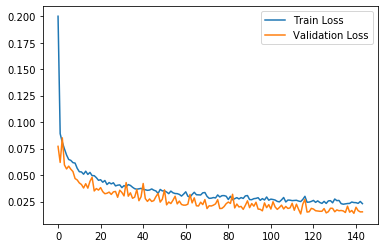

In [16]:
fig, ax = plt.subplots()
plot_max = 0.2
ax.plot([min(plot_max, t) for t in tr_loss], label="Train Loss")
ax.plot([min(plot_max, t) for t in val_loss], label="Validation Loss")
plt.legend()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

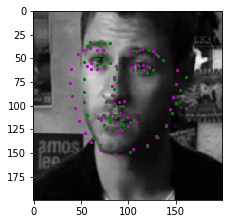

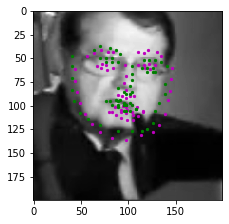

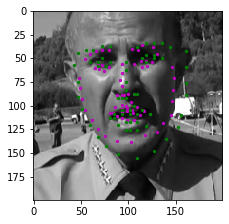

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_smooth_015.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: Optimization function: I picked AMSGrad as the improved version of Adam, the most comonly used momentum function that has empiracally shown to work very well. For Loss I tried mean square error and smooth L1 loss. Smooth L1 loss produced vizualy better results, and thus I picked it over MSE loss.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with AlexNEt architecture and then I developed from there to to fit the network on my local GPU with only 4GB of memory and within that constrain I tried to increase the number of convolutional layers and size of fully connected layers which are very memory heavy.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I set number of epochs to sufficienlty high number and then stopped learning when the validation loss stopped improving for 15 epochs in a row. Batch size I chose empirically by increasing it from 10 to reduce the overfitting (32 still seemed to overfit, i.e. validation error was substantially higher than training error) and limiting it to 64 due to GPU memory limitations

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

/home/igor/projects/ml_utils/cv_course_udacity/p1_facial_keypoints/models.py:13: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
/home/igor/projects/ml_utils/cv_course_udacity/p1_facial_keypoints/models.py:10: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)


[[ 0.04638081  0.00575769  0.00194178  0.06954779 -0.01579304]
 [-0.01446968 -0.00666298 -0.0152354  -0.01174048  0.08946515]
 [-0.0302485   0.04214155 -0.00235923  0.04073856 -0.04691152]
 [-0.03088627 -0.03601928 -0.03694559 -0.05969417 -0.00405865]
 [-0.09072053 -0.10649046 -0.10686804 -0.10561569 -0.06391194]]
(5, 5)


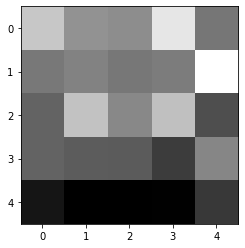

In [19]:
# take the model with tested conv filter
net = Net()
net.load_state_dict(torch.load('saved_models/keypoints_model_smooth_017.pt'))


## Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.features[0].weight.data.cpu()

w = weights1.numpy()

filter_index = 2

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

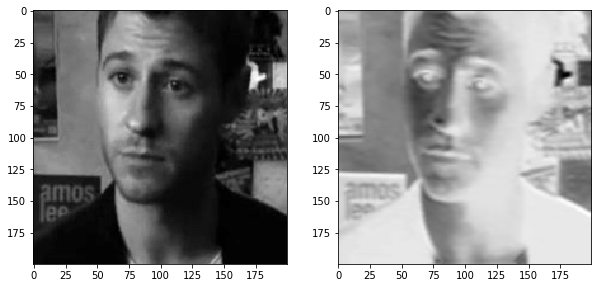

In [20]:
import cv2
##TODO: load in and display any image from the transformed test dataset
image = test_images[0].data   # get the image from it's wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
image = np.squeeze(image)

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

kernel = w[filter_index][0]
filtered = cv2.filter2D(image, -1, kernel)

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(filtered, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: it seems that the filter at index 2 learns something similar to horizontal lines and especially the right edge of the lines, like lips and upper eye edges and lower-right side of the nose. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!